# Disaster Tweets Analysis 
## Real or Not Real?
### Neural Network Experimentation and Tuning

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sea

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from datetime import datetime

import tensorflow as tf
from tensorflow.keras import layers, Input
from tensorflow import set_random_seed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop, SGD
set_random_seed(2)

import re
import nltk

In [3]:
df_train = pd.read_csv('/Users/kirabreeden/Desktop/Grad_School/Northwestern_MSDS/Sping_2020/MSDS_422/Homeworks/HW_8/train_tweets.csv')

df_test = pd.read_csv('/Users/kirabreeden/Desktop/Grad_School/Northwestern_MSDS/Sping_2020/MSDS_422/Homeworks/HW_8/test_tweets.csv')

# EDA

In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
print(df_train['text'])

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object


We can see that the text of our dataframe is full of strange hashtags, quotations, capital letters etc. We will need to clean the text up later. We can also assume that there are probably typos etc so we will want to make sure that all the words are found in the GloVe word embedding we will download. 

/Users/kirabreeden/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


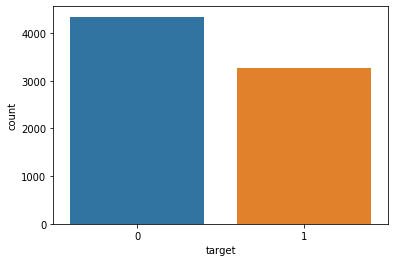

In [6]:
sea.countplot(df_train["target"])

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
keywords = df_train['keyword'].value_counts()

In [9]:
locations = df_train['location'].value_counts()

In [10]:
len(df_train['keyword'].unique())

222

In [11]:
len(df_train['location'].unique())

3342

In [12]:
keywords.sort_values(ascending = False)

fatalities               45
armageddon               42
deluge                   42
harm                     41
body%20bags              41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [13]:
locations.sort_values(ascending = False)

USA                            104
New York                        71
United States                   50
London                          45
Canada                          29
                              ... 
Enterprise, Alabama              1
ÌÏT: 27.9136024,-81.6078532      1
toronto Û¢ dallas               1
Shanghai                         1
los angeles                      1
Name: location, Length: 3341, dtype: int64

In [14]:
df_train.fillna("NANANAN")

,id,keyword,location,text,target
0,1,NANANAN,NANANAN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NANANAN,NANANAN,Forest fire near La Ronge Sask. Canada,1
2,5,NANANAN,NANANAN,All residents asked to 'shelter in place' are ...,1
3,6,NANANAN,NANANAN,"13,000 people receive #wildfires evacuation or...",1
4,7,NANANAN,NANANAN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NANANAN,NANANAN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NANANAN,NANANAN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NANANAN,NANANAN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NANANAN,NANANAN,Police investigating after an e-bike collided ...,1


# Data Preparation

In [15]:
def read_GloVe_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec

In [31]:
#reading from the file to learn the word embedding into the list word_to_vec_map
word_to_index, index_to_word, word_to_vec = read_GloVe_vecs('/Users/kirabreeden/Downloads/glove.6B/glove.6B.300d.txt')

In [ ]:
#we want to remove all the hashtags, capitals, weird twitter text styles etc
def clean_words(text):
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', text).lower() #make all the sentences lowercase
    sentence = sentence.split(" ") #separate words with spaces
    
    for word in list(sentence):
        if word not in word_to_vec:
            sentence.remove(word) #remove words that are not in our embedding
            
    sentence = " ".join(sentence)
    return sentence

In [ ]:
for i in range (df_train.shape[0]):
    df_train.at[i,'text'] = clean_words(df_train.loc[i,'text'])
    
for i in range(df_test.shape[0]):
    df_test.at[i,'text'] = clean_words(df_test.loc[i,'text'])

In [17]:
#Let's figure out the longest text in our input
maxLen = len(max(df_train['text'], key = len).split())

In [18]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [19]:
df_train['text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

We can see now that our text is much cleaner than before. Of course, it is not all perfect but it will be much easier for our model to function now with the more standardized formatting. 

In [20]:
t = Tokenizer()
t.fit_on_texts(df_train['text'])

In [21]:
vocab_size = len(t.word_index) + 1

In [22]:
encoded_text = t.texts_to_sequences(df_train['text'])

In [23]:
padded_text = pad_sequences(encoded_text, maxlen=maxLen, padding='post')

In [24]:
embeddings_index = dict()
f = open('/Users/kirabreeden/Downloads/glove.6B/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/kirabreeden/Downloads/glove.6B/glove.6B.300d.txt'

In [25]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Model Building

In [26]:
X = np.array(padded_text)
y = np.array(df_train['target'])

In [27]:
X_train, X_val, y_train, y_val = train_test_split(padded_text, y, test_size=0.2, random_state = 123)
X_train2, X_val2, y_train2, y_val2 = train_test_split(np.array(df_train['keyword']), y, test_size=0.2, random_state = 123)

In [28]:
y_train_keras = tf.keras.utils.to_categorical(y_train, 2)
y_test_keras = tf.keras.utils.to_categorical(y_val, 2)

In [29]:
padded_text

array([[ 119, 4633,   24, ...,    0,    0,    0],
       [ 189,   45,  229, ...,    0,    0,    0],
       [1751, 1620,    7, ..., 1405,   24, 1106],
       ...,
       [2824, 2401,  709, ...,    0,    0,    0],
       [1145,   41,   43, ...,  131, 2048,  316],
       [   4,  209,   54, ...,    0,    0,    0]], dtype=int32)

In [30]:
#Let's design our model! 
# optimizer = 'SGD'
# optimizer = 'RMSProp'
optimizer = 'adam'
objective = 'binary_crossentropy'

model = tf.keras.Sequential()

model.add(layers.Embedding(vocab_size, 300, weights = [embedding_matrix], input_length = maxLen, trainable=False))
# model.add(layers.LSTM(100, return_sequences = True))
model.add(layers.LSTM(100))
model.add(layers.Dropout(0.1))
# model.add(layers.Flatten())
# model.add(layers.Dense(285, activation = 'relu'))
model.add(layers.Dense(2, activation='softmax'))

model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])

# #TESTING BELOW FOR ADDING MORE FEATURES!

# nlp_input = Input(shape=(maxLen), name='nlp_input')
# meta_input = Input(shape=(1,), name='meta_input')
# emb = layers.Embedding(vocab_size, 300, weights = [embedding_matrix], input_length = maxLen, trainable=False)(nlp_input)
# nlp_out = layers.Bidirectional(layers.LSTM(128, dropout=0.3, recurrent_dropout=0.3))(emb)
# x = layers.concatenate([nlp_out, meta_input])
# x = layers.Dense(2, activation='softmax')(x)
# model = tf.keras.Model(inputs=[nlp_input , meta_input], outputs=[x])


# model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [72]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 27, 300)           3677100   
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
Total params: 3,837,702
Trainable params: 160,602
Non-trainable params: 3,677,100
_________________________________________________________________
None


In [73]:
#Let's train our model
start=datetime.now()
mod = model.fit(X_train, y_train_keras, epochs = 10, validation_data = (X_val, y_test_keras), batch_size = 64)
end=datetime.now()
print("Train time: ", end-start)

Train on 6090 samples, validate on 1523 samples
Epoch 1/10
6090/6090 [==============================] - 5s 803us/sample - loss: 0.4978 - acc: 0.7665 - val_loss: 0.4474 - val_acc: 0.8030
Epoch 2/10
6090/6090 [==============================] - 4s 585us/sample - loss: 0.4196 - acc: 0.8236 - val_loss: 0.4294 - val_acc: 0.8148
Epoch 3/10
6090/6090 [==============================] - 4s 604us/sample - loss: 0.3925 - acc: 0.8358 - val_loss: 0.4433 - val_acc: 0.8037
Epoch 4/10
6090/6090 [==============================] - 3s 569us/sample - loss: 0.3746 - acc: 0.8442 - val_loss: 0.4241 - val_acc: 0.8148
Epoch 5/10
6090/6090 [==============================] - 4s 583us/sample - loss: 0.3550 - acc: 0.8557 - val_loss: 0.4289 - val_acc: 0.8129
Epoch 6/10
6090/6090 [==============================] - 3s 568us/sample - loss: 0.3312 - acc: 0.8642 - val_loss: 0.4663 - val_acc: 0.8050
Epoch 7/10
6090/6090 [==============================] - 3s 567us/sample - loss: 0.3114 - acc: 0.8755 - val_loss: 0.4526 - va

In [74]:
scores = model.evaluate(X_val, y_test_keras, verbose=1)
print("Accuracy:", scores[1]) 

1523/1523 [==============================] - 0s 268us/sample - loss: 0.5722 - acc: 0.8063
Accuracy: 0.8063033


## Evaluation

In [3]:
results = pd.DataFrame({"Embedding": ["50"], "Layer setup": [("embedding, lstm(128), dense(256), flatten, dense(1)")], "Optimizer": ['adam'], "Loss": ["binary_crossentropy"],"Number of Epochs": [3], "Training Time":["00:19.941210"], "Training Set Accuracy":[0.9780], "Test Set Accuracy":[0.79382795], "Kaggle Score":["0.57055"], "Notes": ["Incorrect submission format"]})
new_row = {"Embedding": "50", "Layer setup": ("embedding, flatten, dense(1)"), "Optimizer": 'adam', "Loss": "binary_crossentropy", "Number of Epochs": 5, "Training Time":"00:01.453087", "Training Set Accuracy":0.9765, "Test Set Accuracy":0.7354, "Kaggle Score":"0.58179", "Notes": "Incorrect submission format"}
results = results.append(new_row, ignore_index = True)

new_row1 = {"Embedding": "50", "Layer setup": ("embedding, LSTM(100), dense(1)"), "Optimizer": 'adam', "Loss": "binary_crossentropy", "Number of Epochs": 5, "Training Time":"00:21.347097", "Training Set Accuracy":0.8560, "Test Set Accuracy":0.8122, "Kaggle Score":"0.57055", "Notes": "Incorrect submission format"}
results = results.append(new_row1, ignore_index = True)

new_row2 = {"Embedding": "50", "Layer setup": ("embedding, LSTM(100), dense(1)"), "Optimizer": 'adam', "Loss": "binary_crossentropy", "Number of Epochs": 10, "Training Time":"00:28.716669", "Training Set Accuracy":0.8422, "Test Set Accuracy":0.8129, "Kaggle Score":"0.78220", "Notes": "fixed binary"}
results = results.append(new_row2, ignore_index = True)

new_row3 = {"Embedding": "300", "Layer setup": ("embedding, LSTM(100), flatten, dense(2)"), "Optimizer": 'adam', "Loss": "binary_crossentropy", "Number of Epochs": 10, "Training Time":"00:37.790437", "Training Set Accuracy":0.9534, "Test Set Accuracy":0.7925, "Kaggle Score":"Not submitted", "Notes": "flatten seems to quickly overfit training data without improving test data performance"}
results = results.append(new_row3, ignore_index = True)

new_row4 = {"Embedding": "300", "Layer setup": ("embedding, LSTM(100), dense(285), dense(2)"), "Optimizer": 'adam', "Loss": "binary_crossentropy", "Number of Epochs": 3, "Training Time":"00:14.599000", "Training Set Accuracy":0.8309, "Test Set Accuracy":0.8037, "Kaggle Score":"0.78118", "Notes": ""}
results = results.append(new_row4, ignore_index = True)

new_row5 = {"Embedding": "300", "Layer setup": ("embedding, LSTM(100), LSTM(100), dense(2)"), "Optimizer": 'adam', "Loss": "binary_crossentropy", "Number of Epochs": 10, "Training Time":"01:09.694141", "Training Set Accuracy":0.9335, "Test Set Accuracy":0.7833, "Kaggle Score":"Not submitted", "Notes": ""}
results = results.append(new_row5, ignore_index = True)

new_row6 = {"Embedding": "300", "Layer setup": ("embedding, LSTM(100), LSTM(100), dense(2)"), "Optimizer": 'adam', "Loss": "binary_crossentropy", "Number of Epochs": 5, "Training Time":"00:36.284840", "Training Set Accuracy":0.8591, "Test Set Accuracy":0.8056, "Kaggle Score":"Not submitted", "Notes": ""}
results = results.append(new_row6, ignore_index = True)

new_row7 = {"Embedding": "300", "Layer setup": ("embedding, LSTM(100), dense(2)"), "Optimizer": 'adam', "Loss": "binary_crossentropy", "Number of Epochs": 5, "Training Time":"00:23.097422", "Training Set Accuracy":0.8494, "Test Set Accuracy":0.8148, "Kaggle Score":"0.79345", "Notes": "Similar to index 2 except we use the 300 embedding here"}
results = results.append(new_row7, ignore_index = True)

new_row8 = {"Embedding": "300", "Layer setup": ("embedding, LSTM(100), dense(2)"), "Optimizer": 'SGD', "Loss": "binary_crossentropy", "Number of Epochs": 177, "Training Time":"", "Training Set Accuracy":"not remarkable", "Test Set Accuracy":"not remarkable", "Kaggle Score":"", "Notes": "SGD seems to improve much slower and levels out aroun 80% test accuracy like all the previous ones"}
results = results.append(new_row8, ignore_index = True)

new_row9 = {"Embedding": "300", "Layer setup": ("embedding, LSTM(100), dense(2)"), "Optimizer": 'RMSProp', "Loss": "binary_crossentropy", "Number of Epochs": 4, "Training Time":"00:23.873722", "Training Set Accuracy":"0.8383", "Test Set Accuracy":"0.8129", "Kaggle Score":"0.78732", "Notes": "RMSProp seems like a very similar performance to adam"}
results = results.append(new_row9, ignore_index = True)

new_row10 = {"Embedding": "300", "Layer setup": ("embedding, LSTM(100), dropout(0.3), dense(2)"), "Optimizer": 'adam', "Loss": "binary_crossentropy", "Number of Epochs": 10, "Training Time":"00:39.470225", "Training Set Accuracy":"0.9179", "Test Set Accuracy":"0.7873", "Kaggle Score":"", "Notes": "Even with dropout layers we do not seem to get much improvement in overfitting..."}
results.append(new_row10, ignore_index = True)


,Embedding,Layer setup,Optimizer,Loss,Number of Epochs,Training Time,Training Set Accuracy,Test Set Accuracy,Kaggle Score,Notes
0,50,"embedding, lstm(128), dense(256), flatten, den...",adam,binary_crossentropy,3,00:19.941210,0.978,0.793828,0.57055,Incorrect submission format
1,50,"embedding, flatten, dense(1)",adam,binary_crossentropy,5,00:01.453087,0.9765,0.7354,0.58179,Incorrect submission format
2,50,"embedding, LSTM(100), dense(1)",adam,binary_crossentropy,5,00:21.347097,0.856,0.8122,0.57055,Incorrect submission format
3,50,"embedding, LSTM(100), dense(1)",adam,binary_crossentropy,10,00:28.716669,0.8422,0.8129,0.78220,fixed binary
4,300,"embedding, LSTM(100), flatten, dense(2)",adam,binary_crossentropy,10,00:37.790437,0.9534,0.7925,Not submitted,flatten seems to quickly overfit training data...
5,300,"embedding, LSTM(100), dense(285), dense(2)",adam,binary_crossentropy,3,00:14.599000,0.8309,0.8037,0.78118,
6,300,"embedding, LSTM(100), LSTM(100), dense(2)",adam,binary_crossentropy,10,01:09.694141,0.9335,0.7833,Not submitted,
7,300,"embedding, LSTM(100), LSTM(100), dense(2)",adam,binary_crossentropy,5,00:36.284840,0.8591,0.8056,Not submitted,
8,300,"embedding, LSTM(100), dense(2)",adam,binary_crossentropy,5,00:23.097422,0.8494,0.8148,0.79345,Similar to index 2 except we use the 300 embed...
9,300,"embedding, LSTM(100), dense(2)",SGD,binary_crossentropy,177,,not remarkable,not remarkable,,SGD seems to improve much slower and levels ou...


# Predictions

In [76]:
encoded_text_kaggle = t.texts_to_sequences(df_test['text'])
padded_text_kaggle = pad_sequences(encoded_text_kaggle, maxlen=maxLen, padding='post')
kaggle_x_pred = np.array(padded_text_kaggle)
y_pred = model.predict(kaggle_x_pred)

In [77]:
y_pred

array([[0.8821808 , 0.11781917],
       [0.01164644, 0.9883535 ],
       [0.31802747, 0.68197256],
       ...,
       [0.00205649, 0.99794346],
       [0.07263281, 0.92736727],
       [0.23798156, 0.7620184 ]], dtype=float32)

# Kaggle Submissions

In [78]:
submission_target = []
for i in y_pred: 
    if i[0] > i[1]: 
        submission_target.append(0)
    else: 
        submission_target.append(1)

In [79]:
#set up the kaggle submission file
sub = pd.DataFrame({'id':np.array(df_test['id']),'target':submission_target})
#sub.to_csv('subBin4.csv', index=False)


As you can see below my best kaggle submission was about 79% accurate. This seemed to be the point where my model got stuck and I couldn't seem to get it past that...

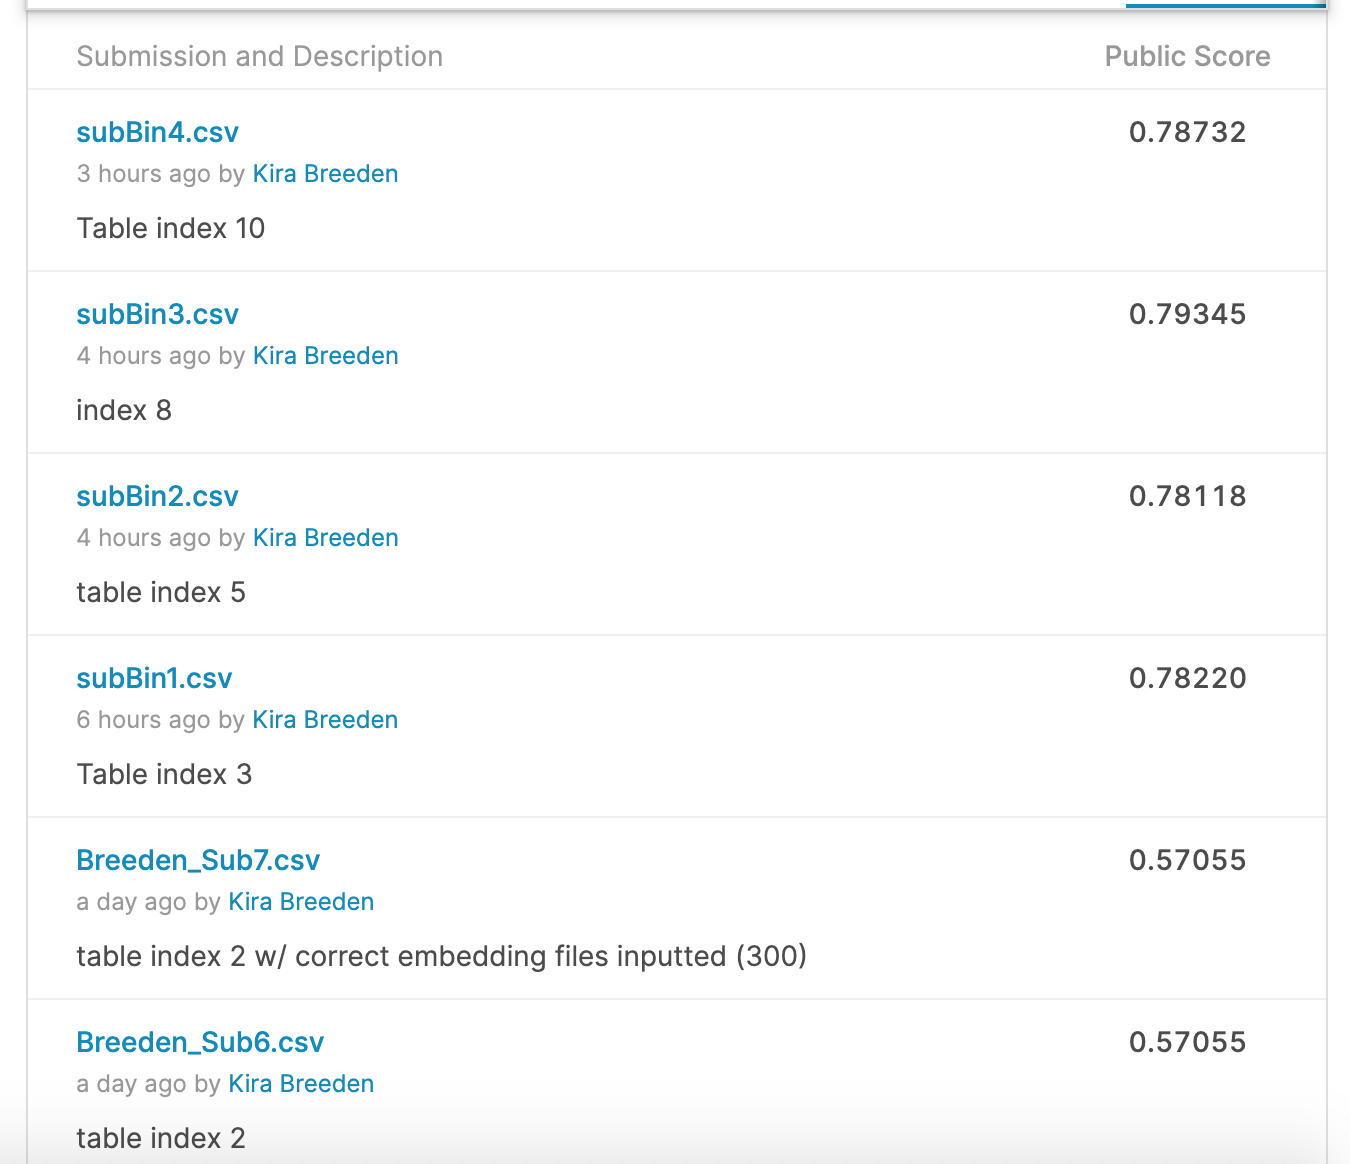

# Management Question

Suppose management is thinking about using a language model to classify written customer reviews and call and complaint logs. If the most critical customer messages can be identified, then customer support personnel can be assigned to contact those customers.

How would you advise senior management? What kinds of systems and methods would be most relevant to the customer services function? Considering the results of this assignment in particular, what is needed to make an automated customer support system that is capable of identifying negative customer feelings? What can data scientists do to make language models more useful in a customer service function?

I would recommend using some sort of RNN layer in the model. The computational power and flexibility of this layer type lends itself well to different lengths of inputs which for us is extrememly useful for text analysis. I would definitely approach this as a classification problem where we either classify negative versus positive customer sentiment or whatever other classes of customer service messages that management wants to know about. 

After looking at the results of this study, I would absolutely recommend spending plenty of time preparing and cleaning the data. This may be slightly less necessary for a customer service system, but when analyzing text from sources like Twitter, we have to recognize that there will probably be many typos, many hashtags, emojis, etc. These additions could easily add unnecessary complexity to a model and lower the accuracy quite a bit. Additionally, using LSTM layers proved to be very useful for me and the number of epochs was quite important in this study. My models were very quick to overfit when working with the adam optimizer as shown in the image below. The sweet spot seemed to be at least 3 epochs and no more than 10 epochs. 


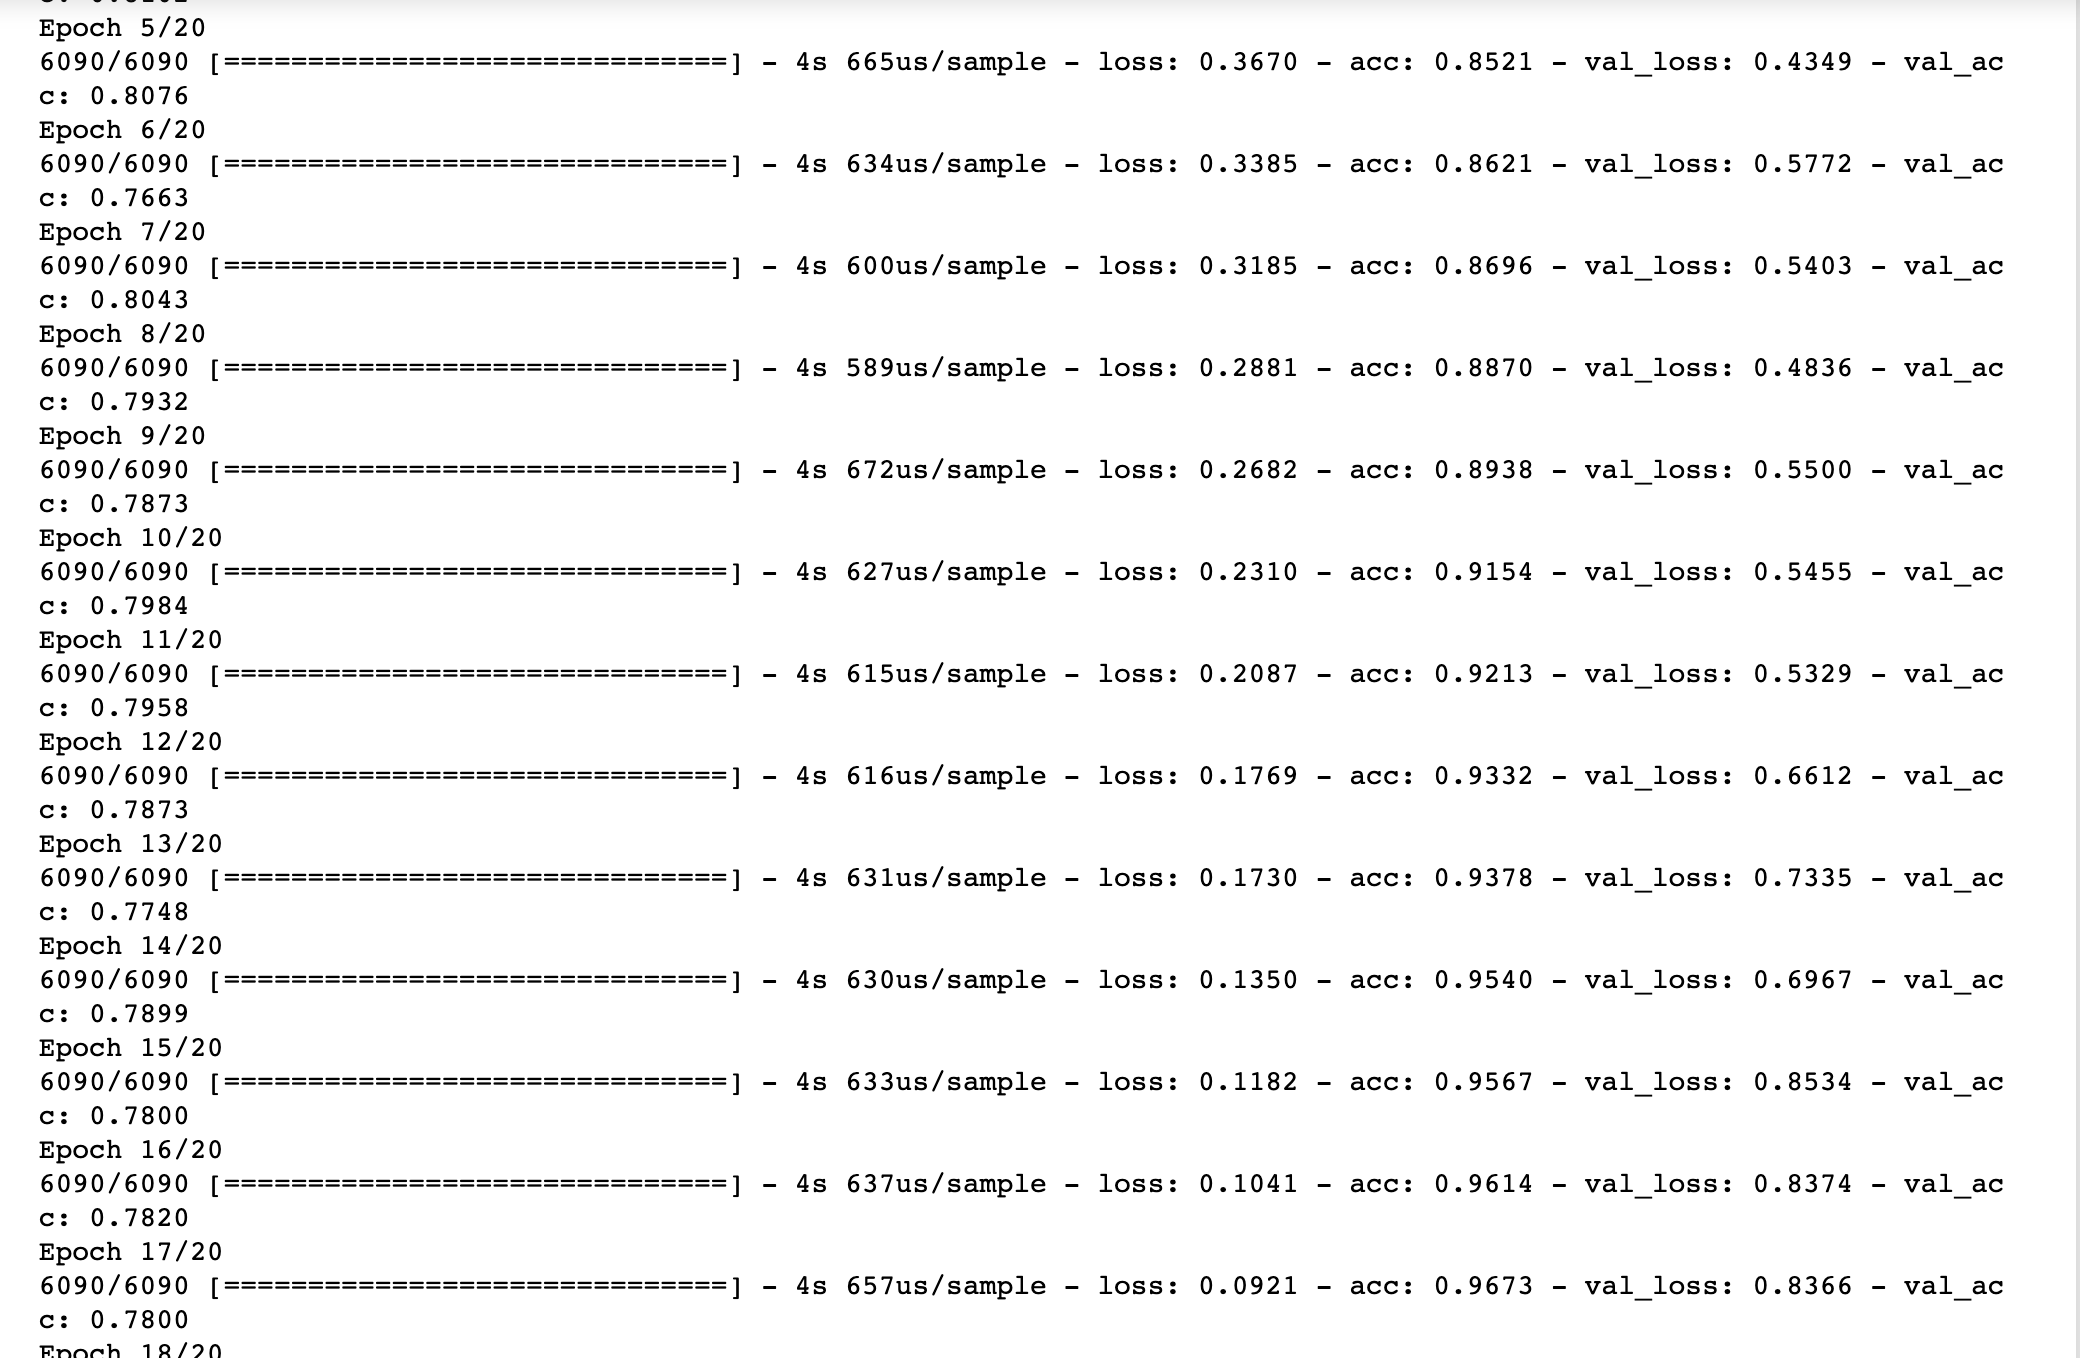

As far as data science and customer service in general, I am not entirely sure if something like this exists already but immediately feeding responses in an system where they are "cleaned" could help a lot. I am sure this sort of thing is beginning to happen a lot more naturally with the invent and wide-usage of spell-checking extensions etc. 

This type of model does not take quite as long as, say, image recognition but there needs to be an understanding among management that there is a need for good computing power and memory storage for problems like this. Not only this, but they need to understand that often, the more complex the model, the longer it will take to run. In the case of these RNNS we actually want to stay away from models with too many layers as we begin to run into the vanishing gradients problem if our models become too deep. Establishing how much we care about accuracy with management would be a good idea. We would need to investigate what the consequences of false classification would be and how important it is to avoid these consequences. 

Lastly, I would make sure to calrify with any managment involved in NLP that data preperation and EDA is so important for problems like this and the actual model does not take nearly as long to run as the EDA and data preparation takes to complete. 

My hypothesis for my experiment here is that my model got continuously caught in a local optimum and could not get out. I even varied by batch size and unfortunately it still did not improve the model performance. 